# CPSC 330 Lecture 9

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Evaluation metrics True/False (10 min)
- Introducing some other classifiers (20 min)
- Break (5 mins)
- Ensembles: averaging (20 min)
- Ensembles: stacking (20 min)
- Summary

Piazza:

- Ensembles True/False questions

## Announcements

- hw schedule for the rest of the course posted at https://github.com/UBC-CS/cpsc330#homework-schedule
- hw4 posted, due Monday 11:59pm
- Evaluation metrics true/false: https://piazza.com/class/kb2e6nwu3uj23?cid=283
- Midterm format poll: https://piazza.com/class/kb2e6nwu3uj23?cid=281

## Learning objectives

- Name a few popular tree-based classifier.
- Name a few key hyperparameters of random forest classifiers.
- Weigh the pros and cons of using a classifier from outside scikit-learn.
- Employ ensemble classifier approaches, in particular model averaging and stacking
- Compare averaging vs. stacking
- Interpret the coefficients of the meta-classifier in the case of stacking

In [169]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [20]:
plt.rcParams['font.size'] = 16

In [125]:
from IPython.display import display

In [96]:
import re
import graphviz
from sklearn.tree import export_graphviz

def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(tree, out_file=None, feature_names=feature_names, class_names=tree.classes_.astype(str), impurity=False)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

## Introducing some other classifiers (20 min)

- SVM?
- Random forest
- XGB, Catboost?

In [40]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')

Today I will use a smaller data set for speed of the demos:

In [41]:
cc_df = cc_df.sample(frac=0.1)

In [42]:
df_train, df_test = train_test_split(cc_df, random_state=123)

In [43]:
df_train.shape

(21360, 31)

In [44]:
X_train = df_train.drop(columns=['Class'])
y_train = df_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [147]:
pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
]) 

In [151]:
score_method = 'average_precision'

In [152]:
lr_results = pd.DataFrame(cross_validate(pipe_lr, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
lr_results

fit_time       0.152092
score_time     0.004988
test_score     0.690253
train_score    0.773068
dtype: float64

In [47]:
dt = DecisionTreeClassifier(class_weight='balanced') # scaling not needed

In [153]:
dt_results = pd.DataFrame(cross_validate(dt, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
dt_results

fit_time       0.161050
score_time     0.002695
test_score     0.510938
train_score    1.000000
dtype: float64

How about some other classifiers?

In [75]:
from sklearn.ensemble import RandomForestClassifier

- This is basically the average of a bunch of random decision trees. 
- We'll talk about averaging later today!

In [50]:
rf = RandomForestClassifier(class_weight='balanced', random_state=999) # scaling not needed

In [154]:
rf_results = pd.DataFrame(cross_validate(rf, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
rf_results

fit_time       2.023708
score_time     0.024301
test_score     0.760333
train_score    1.000000
dtype: float64

This gets a better score!

In [155]:
summary = pd.DataFrame([lr_results, dt_results, rf_results], index=["logistic regression", "decision tree", "random forest"])
summary.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
random forest,2.023708,0.024301,0.760333,1.000000
logistic regression,0.152092,0.004988,0.690253,0.773068
decision tree,0.161050,0.002695,0.510938,1.000000


### What are these random forests you speak of?

- They are a collection of decision trees.
- Each tree "votes" on the prediction, majority rules (more on this later).
- Each tree (and split) is limited in the number of features it can look at.
- Each tree is training on a slightly different version of the dataset. 

We can actually look at the sub-trees in a trained random forest:



Tree 1


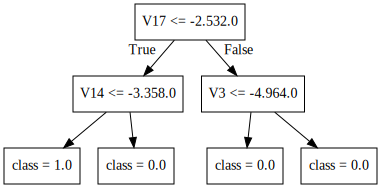



Tree 2


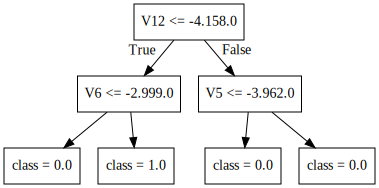



Tree 3


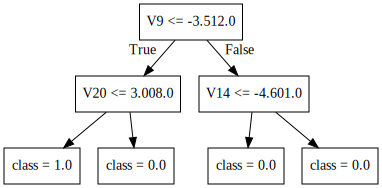

In [131]:
rf_demo = RandomForestClassifier(max_depth=2, n_estimators=3)
rf_demo.fit(X_train, y_train)
for i, tree in enumerate(rf_demo.estimators_):
    print("\n\nTree", i+1)
    display(display_tree(X_train.columns, tree))

Note that they look at different features. 

## Q&A

(Pause for Q&A)

<br><br><br><br>

Some notable hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)

In [143]:
# ??RandomForestClassifier

- We can also try some other tree-based classifiers from outside sklearn.
- There are more "fancy" are are **extremely popular**.  
- Over time, people created "sklearn-friendly" wrappers so that these classifiers are compatible with all that we know & love.
  - As long as they implement `fit` and `predict` and `predict_proba` and `score` we can plug them right in.
  - Important to note that all of these **do** implement `predict_proba` so we can use something like ROC AUC.
  - The probability scores come from the variation in the votes across trees, and other fancier sources.

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

`XGBClassifier` doesn't have an easy implementation of `class_weight='balanced'` AFAIK.

In [161]:
vc = y_train.value_counts()
vc = vc/vc.iloc[1]
vc

0    463.347826
1      1.000000
Name: Class, dtype: float64

In [224]:
classifiers = {
    'logistic regression' : pipe_lr,
    'decision tree' : dt,
    'random forest' : rf,
    'XGBoost' : XGBClassifier(scale_pos_weight=500, random_state=999), 
    'LightGBM' : LGBMClassifier(class_weight='balanced', random_state=999),
    'CatBoost' : CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=999)
}

In [225]:
results = dict()
for name, classifier in classifiers.items():
    print(name)
    results[name] = pd.DataFrame(cross_validate(classifier, X_train, y_train, scoring=score_method, return_train_score=True)).mean()

logistic regression
decision tree
random forest
XGBoost
LightGBM
CatBoost


In [226]:
results = pd.DataFrame(results).T
results.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
CatBoost,8.642796,0.006026,0.774651,1.000000
XGBoost,0.817697,0.007424,0.772250,1.000000
random forest,2.046312,0.025767,0.762367,1.000000
LightGBM,0.388395,0.012366,0.757898,1.000000
logistic regression,0.160699,0.004880,0.690253,0.773068
decision tree,0.180556,0.002764,0.479016,1.000000


My thoughts:

- Keep in mind all of the above is with:
  - Default hyperparameters (except `class_weight`)
  - A particular scoring metric
  - 5-fold CV
- All the trees totally overfit
  - We may do better by tweaking the hyperparameters
- Look at the fit times! And the score times are also interesting.
- Note that CatBoost took about 10x longer than XGBoost and the scores only differ by <1%
  - We took the mean of the sub-scores, but we might want to look more closely.

#### What classifier should I use?!

- Cop out answer: whichever gets the highest CV score.
  - But we shouldn't overuse the validation set.
  - This seems more reasonable when you have more data.
  - It's time-consuming.
- You may also have a reason to choose one over another.
- One reason is _interpretability_, which we'll talk a bit more about next week.
  - This is an area of growing interest and concern in ML.
- Other considerations could be speed (fit and/or predict), maintainability of the code.
- Finally, you could use all of them! (That's what the rest of today is about!)

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Break (5 min)

<br><br>

## Ensembles: averaging (20 min)

Earlier we looked at a bunch of classifiers:

In [173]:
classifiers

{'logistic regression': Pipeline(steps=[('scale', StandardScaler()),
                 ('lr', LogisticRegression(max_iter=1000))]),
 'decision tree': DecisionTreeClassifier(class_weight='balanced'),
 'random forest': RandomForestClassifier(class_weight='balanced'),
 'XGBoost': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None, gamma=None,
               gpu_id=None, importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=500, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None),
 'LightGBM': LGBMClassifier(class_weight='balanced'),
 'CatBoost': <catboost.core.C

Earlier we training a logistic regression model.

In [227]:
averaging_model = VotingClassifier(list(classifiers.items()), voting='soft') # need the list() here for cross_val to work!

- This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifiers.
  - Or, more generally, classifier pipelines!
- Note the `voting='soft'`
  - By default (`voting='hard'`) it uses the output of `predict` and actually votes.
  - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.
  - The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [228]:
averaging_model.fit(X_train, y_train);

Note: it seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.

In [229]:
averaging_model.predict(X_test[100:101])

array([1])

For hard voting, these are the votes:

In [230]:
r1 = {name : classifier.predict(X_test[100:101])[0] for name, classifier in averaging_model.named_estimators_.items()}
r1

{'logistic regression': 1,
 'decision tree': 0,
 'random forest': 1,
 'XGBoost': 1,
 'LightGBM': 1,
 'CatBoost': 1}

For soft voting, these are the scores:

In [231]:
r2 = {name : classifier.predict_proba(X_test[100:101])[0] for name, classifier in averaging_model.named_estimators_.items()}
pd.DataFrame(r2).T

,0,1
logistic regression,0.068658,0.931342
decision tree,1.000000,0.000000
random forest,0.300000,0.700000
XGBoost,0.000010,0.999990
LightGBM,0.000682,0.999318
CatBoost,0.000789,0.999211


In [232]:
pd.DataFrame(r2).T.mean()

0    0.228356
1    0.771644
dtype: float64

(Aside: the probability scores from `DecisionTreeClassifier` are pretty bad)

Let's see how well this model performs.

In [235]:
vot_res = pd.DataFrame(cross_validate(averaging_model, X_train, y_train, scoring=score_method, return_train_score=True)).mean()
vot_res

fit_time       11.506279
score_time      0.068168
test_score      0.785969
train_score     1.000000
dtype: float64

In [249]:
results_with_avg = pd.concat((results, pd.DataFrame(vot_res, columns=["Voting"]).T))
results_with_avg.sort_values(by=["test_score"], ascending=False)

,fit_time,score_time,test_score,train_score
Voting,11.506279,0.068168,0.785969,1.000000
CatBoost,8.642796,0.006026,0.774651,1.000000
XGBoost,0.817697,0.007424,0.772250,1.000000
random forest,2.046312,0.025767,0.762367,1.000000
LightGBM,0.388395,0.012366,0.757898,1.000000
logistic regression,0.160699,0.004880,0.690253,0.773068
decision tree,0.180556,0.002764,0.479016,1.000000


It appears that we did a bit better than even our best classifier!

- Question: how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??
  
<br><br><br>

Here's how this can work:

| Example | log reg    | rand for     | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


In short, as long as the different models make different mistakes, this can work.

This is amazing, why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

Back to ensembling: when can I do this?

- You can comebine completely different estimators, or similar estimators.
  - (In fact, a random forest itself is an ensemble of decision trees.)
- But you can also try different hyperparameter values.
  - So... the hyperparameters of the ensemble now go even deeper.
  - The inception never ends... 

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Ensembles: stacking (20 min)

- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, instead use their outputs as _inputs to another model_.
- By default for classification, it uses logistic regression.
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [250]:
from sklearn.ensemble import StackingClassifier

The code starts to get too slow here; I'm going to remove CatBoost

In [251]:
classifiers_nocat = classifiers.copy()
del classifiers_nocat["CatBoost"]

In [252]:
stacking_model = StackingClassifier(list(classifiers_nocat.items()))

In [253]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))
  - It is fitting the base estimators on the training fold
  - And the predicting on the validation fold
  - And then fitting the meta-estimator on that output (on the validation fold)

In [254]:
stacking_model.predict(X_test[100:101])

array([1])

In [255]:
stacking_model.predict_proba(X_test[100:101])

array([[0.08733487, 0.91266513]])

(This is the `predict_proba` from logistic regression)

Let's see how well this model performs.

In [256]:
pd.DataFrame(cross_validate(stacking_model, X_train, y_train, scoring=score_method, return_train_score=True)).mean()

fit_time       16.922682
score_time      0.057425
test_score      0.781834
train_score     1.000000
dtype: float64

- The situation here is a bit mind-boggling.
- AFAIK on each fold of cross-validation it is doing cross-validation.
- And then in there you might have pipelines and...
- This is really loops within loops within loops within loops...

Here is the input features (X) to the meta-model:

In [271]:
r3 = {name : classifier.predict_proba(X_test[100:101])[0] for name, classifier in stacking_model.named_estimators_.items()}
r3 = pd.DataFrame(r3).T
r3

,0,1
logistic regression,0.068658,0.931342
decision tree,1.000000,0.000000
random forest,0.310000,0.690000
XGBoost,0.000010,0.999990
LightGBM,0.000682,0.999318


(Because this needs to work for multi-class now I'm not quite sure if both probabilities are going in or just one - I think just one - this is a bit simpler for regression!)

- If the meta-model is logistic regression (which it is by default), you are taking a weighted average of these outputs and learning the weights from the data.

In [276]:
stacking_model.final_estimator_.coef_

array([[2.65468467, 1.11690141, 2.30038883, 3.02946163, 2.57597216]])

In [281]:
pd.DataFrame(data=stacking_model.final_estimator_.coef_[0], index=classifiers_nocat.keys(), columns=["Coefficient"])

,Coefficient
logistic regression,2.654685
decision tree,1.116901
random forest,2.300389
XGBoost,3.029462
LightGBM,2.575972


- It seems that the XGBoost is being trusted the most / counting for most.
- We can also try a different final estimator:

In [285]:
stacking_model_tree = StackingClassifier(list(classifiers_nocat.items()), 
                                        final_estimator=DecisionTreeClassifier(max_depth=3))

In [286]:
pd.DataFrame(cross_validate(stacking_model_tree, X_train, y_train, scoring=score_method, return_train_score=True)).mean()

fit_time       19.168481
score_time      0.062120
test_score      0.652996
train_score     0.923158
dtype: float64

In [287]:
stacking_model_tree.fit(X_train, y_train);

The results are not very good. But we can look at the tree:

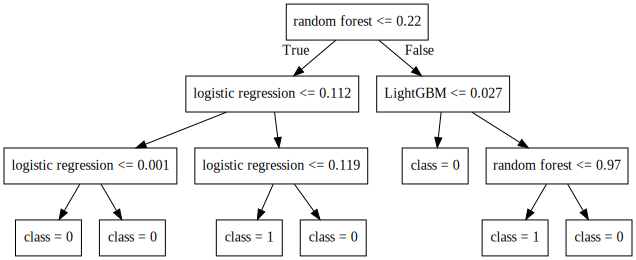

In [289]:
display_tree(list(classifiers_nocat.keys()), stacking_model_tree.final_estimator_)

This is so cool!! (Well,  think so)

#### An effective strategy

- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

## Summary 

- There's a big world of classifiers out there.
  - Tree-based classifiers are particularly popular and effective on a wide range of problems. 
  - These can be much more complex than LogisticRegression, which only learns one coefficient per feature.
- We sometimes need to leave the world of scikit-learn (and more of that later in the course!).
- Ensembles are usually pretty effective.
  - But they trade off code complexity and code speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting, but generally more accuracy.
  - As a bonus, you get to see the coefficients for each base classifier.
- Remember, everything we've done is subject to earlier warnings:
  - Check for small datasets
  - Check the CV folds
  - Check the test set
  - Think carefully about which scoring metric is suitable for your problem

## True/False questions (Piazza)

1. I can decide to average different models even _after_ I (or someone else) have already trained them.
2. Let estimators A, B, and C have scores of 90%, 70%, and 70%, respectively. Then, the maximum score of an ensemble is 90%. 
3. Let estimators A, B, and C have scores of 70%, 70%, and 70%, respectively. Then, the minimum score of an ensemble is 70%.
4. Ensembling often increase your score but they also increase the time spent fitting and predicting.


<br><br><br><br><br><br><br><br><br>